<a href="https://colab.research.google.com/github/JuanaPinzonR/Proyecto_Computacional/blob/main/Proyecto_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Espectro** **Normalizado**

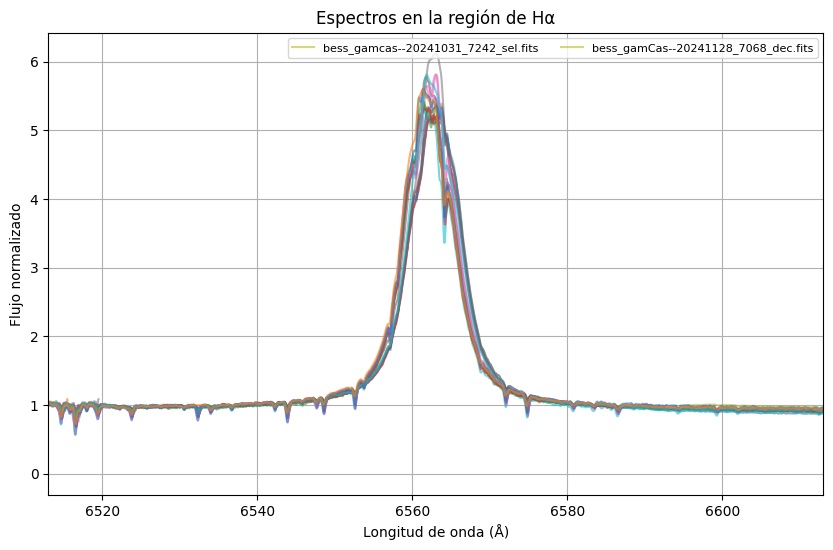

In [29]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

file_list = glob.glob("*.fits")


ha_line = 6563  # Å

plt.figure(figsize=(10, 6))

for file in file_list:
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        crval = header.get("CRVAL1", 0)  # Valor de la primera longitud de onda
        cdelt = header.get("CDELT1", 1)  # Incremento por píxel
        num_pixels = len(data)

        wavelength = crval + cdelt * np.arange(num_pixels)

        valid_range = (wavelength > 6500) & (wavelength < 6600)
        if np.any(valid_range):
            continuum = np.median(data[valid_range])

            if continuum > 0 and not np.isnan(continuum):
                normalized_flux = data / continuum
            else:
                normalized_flux = data  # No normaliza si el continuo es inválido
                print(f"Advertencia: Continuo inválido en {file}")

        else:
            normalized_flux = data

        plt.plot(wavelength, normalized_flux, label=file.split('/')[-1], alpha=0.6)

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros en la región de Hα")
plt.xlim(ha_line - 50, ha_line + 50)
plt.legend(fontsize=8, loc="upper right", ncol=2)
plt.grid()
plt.show()


**Aplicación Filtro Savitzky-Golay y Cálculo EW**

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


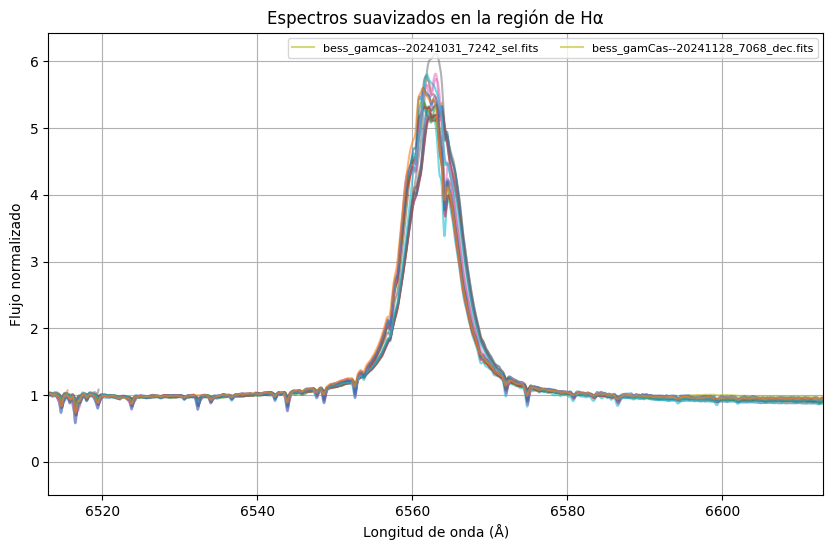

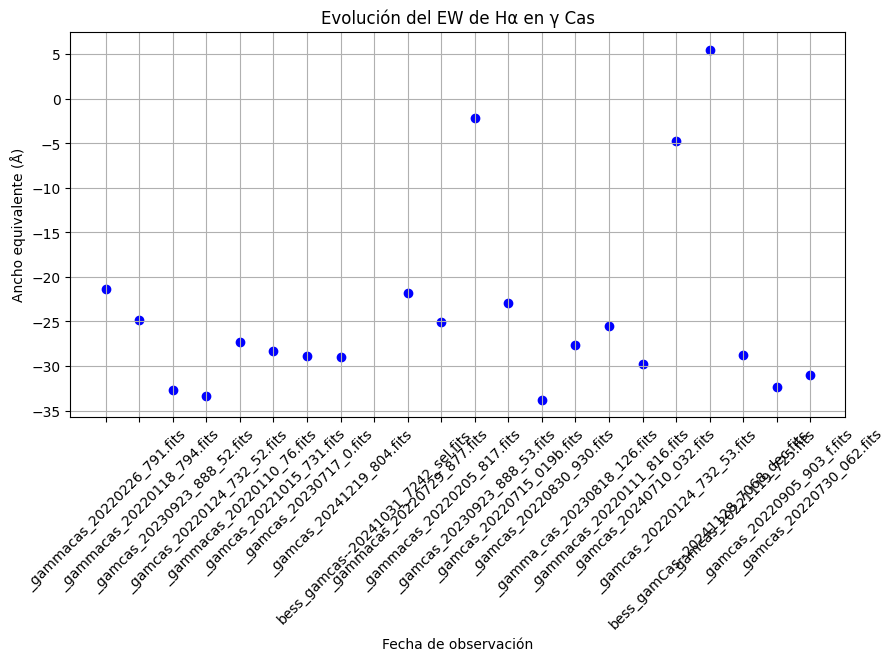

In [30]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

def calcular_ew(wavelength, flux, line_center=6563):
    delta_lambda = np.diff(wavelength).mean()
    continuum_level = np.median(flux[(wavelength > 6500) & (wavelength < 6600)])
    ew = np.sum((1 - flux / continuum_level) * delta_lambda)
    return ew


ew_values = []
file_dates = []

plt.figure(figsize=(10, 6))

for file in file_list:
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        crval = header.get("CRVAL1", 0)
        cdelt = header.get("CDELT1", 1)
        num_pixels = len(data)

        wavelength = crval + cdelt * np.arange(num_pixels)

        valid_range = (wavelength > 6500) & (wavelength < 6600)
        if np.any(valid_range):
            continuum = np.median(data[valid_range])
            if continuum > 0 and not np.isnan(continuum):
                normalized_flux = data / continuum
            else:
                normalized_flux = data  # No normaliza si el continuo es inválido
                print(f"Advertencia: Continuo inválido en {file}")
        else:
            normalized_flux = data

        smoothed_flux = savgol_filter(normalized_flux, window_length=15, polyorder=3)

        ew = calcular_ew(wavelength, smoothed_flux)
        ew_values.append(ew)
        file_dates.append(file)

        plt.plot(wavelength, smoothed_flux, label=file.split('/')[-1], alpha=0.6)

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros suavizados en la región de Hα")
plt.xlim(ha_line - 50, ha_line + 50)
if len(file_list) > 0:
    plt.legend(fontsize=8, loc="upper right", ncol=2)
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(file_dates, ew_values, color='b')
plt.xlabel("Fecha de observación")
plt.ylabel("Ancho equivalente (Å)")
plt.title("Evolución del EW de Hα en γ Cas")
plt.xticks(rotation=45)
plt.grid()
plt.show()


**Verificación FWHM y EW**

<Figure size 1000x600 with 0 Axes>

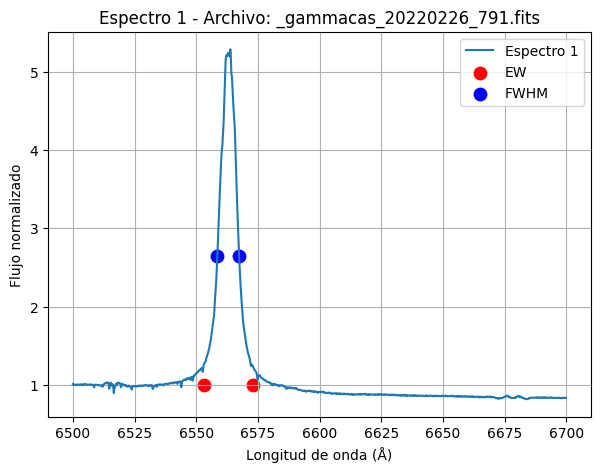

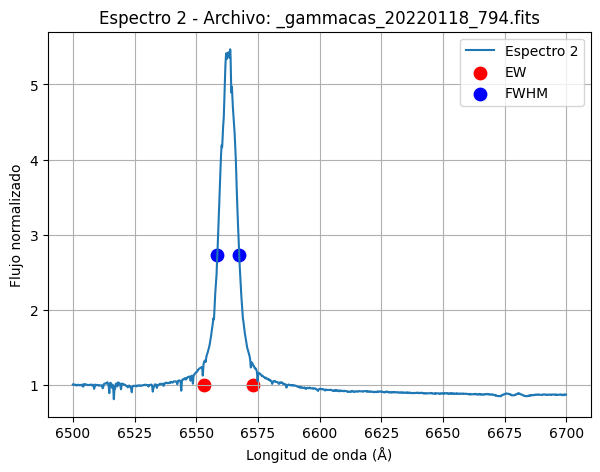

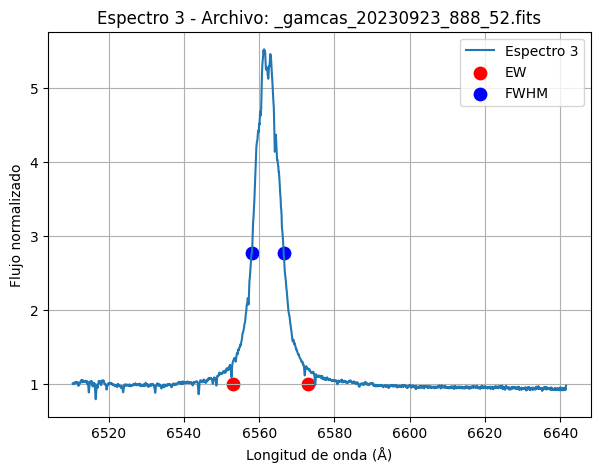

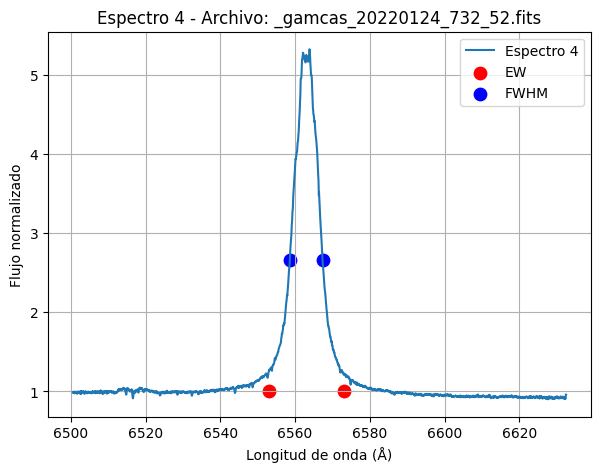

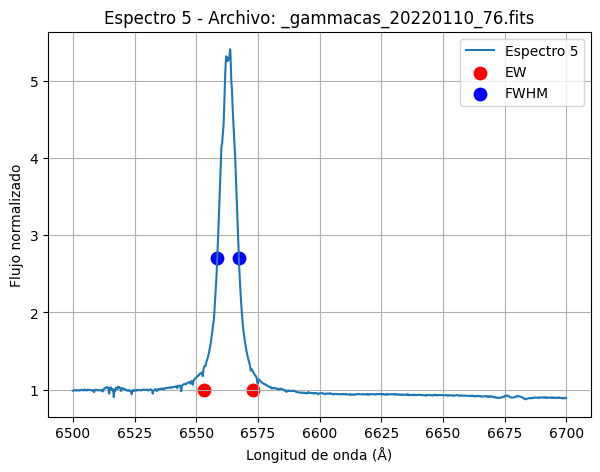

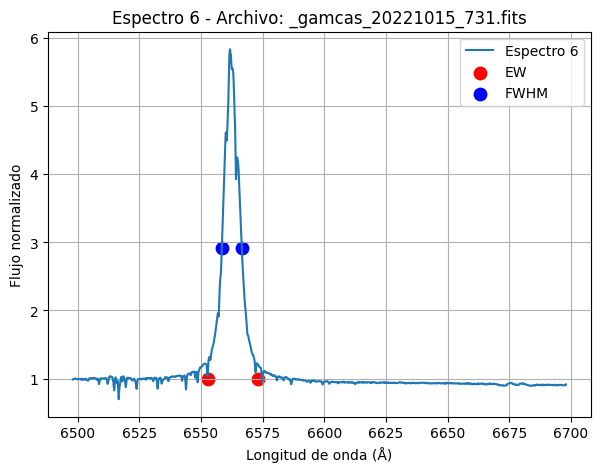

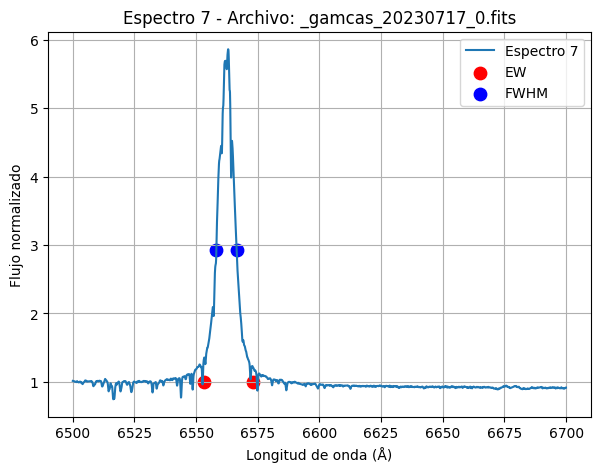

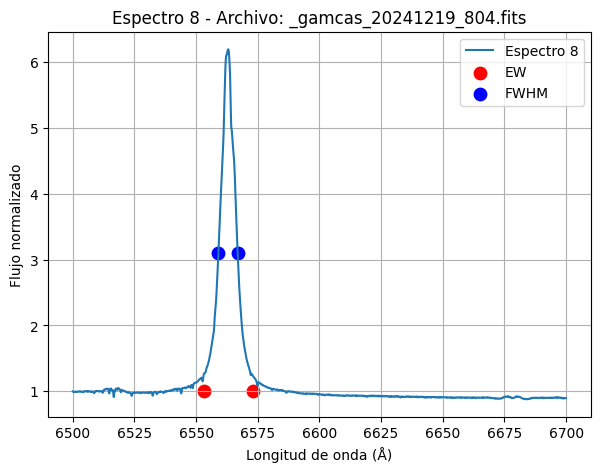

IndexError: index -1 is out of bounds for axis 0 with size 0

In [31]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Obtener lista de archivos FITS
file_list = glob.glob("*.fits")


ha_line = 6563  # Longitud de onda de Hα
plt.figure(figsize=(10, 6))

for i, file in enumerate(file_list):
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

    # Obtener la escala de longitud de onda
    crval = header["CRVAL1"]  # Primera longitud de onda
    cdelt = header["CDELT1"]  # Incremento por píxel
    num_pixels = len(data)
    wavelength = crval + cdelt * np.arange(num_pixels)

    # Normalizar el espectro
    continuum_region = (wavelength > 6500) & (wavelength < 6620)
    continuum = np.median(data[continuum_region])
    normalized_flux = data / continuum

    # Encontrar el máximo del perfil para el FWHM
    peak_idx = np.argmax(normalized_flux)
    peak_flux = normalized_flux[peak_idx]
    half_max = peak_flux / 2

    # Encontrar los puntos donde el flujo cruza la media altura
    left_idx = np.where(normalized_flux[:peak_idx] <= half_max)[0][-1]
    right_idx = np.where(normalized_flux[peak_idx:] <= half_max)[0][0] + peak_idx
    fwhm_wavelengths = [wavelength[left_idx], wavelength[right_idx]]

    # Definir los puntos de EW como los límites de integración
    ew_left = ha_line - 10  # 10 Å a la izquierda de Hα
    ew_right = ha_line + 10  # 10 Å a la derecha de Hα

    # Graficar
    plt.figure(figsize=(7, 5))
    plt.plot(wavelength, normalized_flux, label=f"Espectro {i+1}")
    plt.scatter([ew_left, ew_right], [1, 1], color='red', label="EW", s=80)
    plt.scatter(fwhm_wavelengths, [half_max, half_max], color='blue', label="FWHM", s=80)
    plt.xlabel("Longitud de onda (Å)")
    plt.ylabel("Flujo normalizado")
    plt.title(f"Espectro {i+1} - Archivo: {file}")
    plt.legend()
    plt.grid()
    plt.show()


**FWHM, Velocidad y Desplazamiento**

<ipython-input-32-2eeb7e1474d5>:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew = np.trapz(1 - flux[mask], wavelength[mask])



Resultados:
Archivo		FWHM (Å)	Desplazamiento (Å)	Velocidad (km/s)	EW (Å)
_gammacas_20220226_791.fits	183.33		120.61		5513.05		-35.78
_gammacas_20220118_794.fits	185.14		-46.38		-2119.84		-37.00
_gamcas_20230923_888_52.fits	120.45		-46.40		-2120.98		-35.86
_gamcas_20220124_732_52.fits	116.00		64.65		2955.20		-35.42
_gammacas_20220110_76.fits	183.37		120.66		5515.42		-35.79
_gamcas_20221015_731.fits	29.28		-46.38		-2120.26		-36.32
_gamcas_20230717_0.fits	72.10		-46.58		-2129.09		-37.39
_gamcas_20241219_804.fits	183.47		120.91		5527.02		-38.47
_gammacas_20220729_877.fits	0.09		170.48		7792.73		-34.23
_gammacas_20220205_817.fits	185.14		-46.41		-2121.63		-36.90
_gamcas_20230923_888_53.fits	39.85		-87.20		-3985.98		0.00
_gamcas_20220830_930.fits	29.27		-46.37		-2119.70		-34.80
_gamma_cas_20230818_126.fits	29.39		-46.48		-2124.48		-36.65
_gammacas_20220111_816.fits	183.21		120.66		5515.42		-35.16
_gamcas_20240710_032.fits	0.10		-111.99		-5118.93		-38.46
_gamcas_20220124_732_53.fits	41.60		-

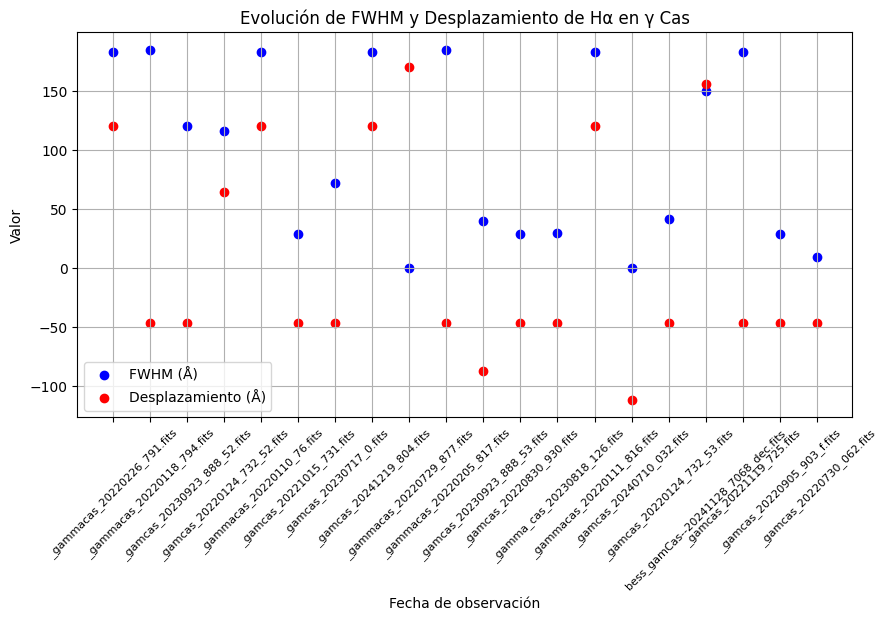

In [32]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Obtener lista de archivos FITS en el directorio
file_list = glob.glob("*.fits")


# Función para calcular el FWHM
def calcular_fwhm(wavelength, flux):
    max_flux = np.min(flux)  # Línea de emisión
    half_max = (1 + max_flux) / 2  # Nivel de la mitad del máximo

    indices = np.where(flux <= half_max)[0]
    if len(indices) < 2:
        return None, None  # FWHM inválido

    left_idx, right_idx = indices[0], indices[-1]
    fwhm_value = wavelength[right_idx] - wavelength[left_idx]
    fwhm_points = [wavelength[left_idx], wavelength[right_idx]]

    return fwhm_value, fwhm_points

# Función para calcular el desplazamiento Doppler
def calcular_desplazamiento_pico(wavelength, flux, lambda_rest=6563):
    peak_index = np.argmin(flux)  # Índice del pico más profundo
    lambda_peak = wavelength[peak_index]
    desplazamiento = lambda_peak - lambda_rest
    velocidad = (desplazamiento / lambda_rest) * 3e5  # km/s usando Doppler
    return lambda_peak, desplazamiento, velocidad

# Función para calcular el Equivalent Width (EW)
def calcular_ew(wavelength, flux, lambda_rest=6563, ancho=10):
    left_limit = lambda_rest - ancho
    right_limit = lambda_rest + ancho
    mask = (wavelength >= left_limit) & (wavelength <= right_limit)

    ew = np.trapz(1 - flux[mask], wavelength[mask])
    return ew

# Listas para almacenar resultados
fwhm_values = []
desplazamientos = []
velocidades = []
ew_values = []
file_names = []

for file_fits in file_list:
    with fits.open(file_fits) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        crval = header["CRVAL1"]
        cdelt = header["CDELT1"]
        num_pixels = len(data)
        wavelength = crval + cdelt * np.arange(num_pixels)

    # Normalización del flujo
    continuum = np.median(data[(wavelength > 6500) & (wavelength < 6600)])
    normalized_flux = data / continuum

    # Cálculos
    fwhm_result, fwhm_points = calcular_fwhm(wavelength, normalized_flux)
    lambda_peak, desplazamiento, velocidad = calcular_desplazamiento_pico(wavelength, normalized_flux)
    ew_result = calcular_ew(wavelength, normalized_flux)

    # Guardar resultados
    if fwhm_result is not None:
        fwhm_values.append(fwhm_result)
        desplazamientos.append(desplazamiento)
        velocidades.append(velocidad)
        ew_values.append(ew_result)
        file_names.append(file_fits)

# Imprimir tabla de resultados
print("\nResultados:")
print("Archivo\t\tFWHM (Å)\tDesplazamiento (Å)\tVelocidad (km/s)\tEW (Å)")
for i in range(len(file_names)):
    print(f"{file_names[i]}\t{fwhm_values[i]:.2f}\t\t{desplazamientos[i]:.2f}\t\t{velocidades[i]:.2f}\t\t{ew_values[i]:.2f}")

# Gráfica resumen de evolución de FWHM, desplazamiento y EW
plt.figure(figsize=(10, 5))
plt.scatter(file_names, fwhm_values, color='b', label='FWHM (Å)')
plt.scatter(file_names, desplazamientos, color='r', label='Desplazamiento (Å)')
plt.xlabel("Fecha de observación")
plt.ylabel("Valor")
plt.title("Evolución de FWHM y Desplazamiento de Hα en γ Cas")
plt.xticks(rotation=45, fontsize=8)
plt.legend()
plt.grid()
plt.show()


**Dependencia FWHM con la velocidad Kepleriana (Implementación del Disco Kepleriano al modelo)**

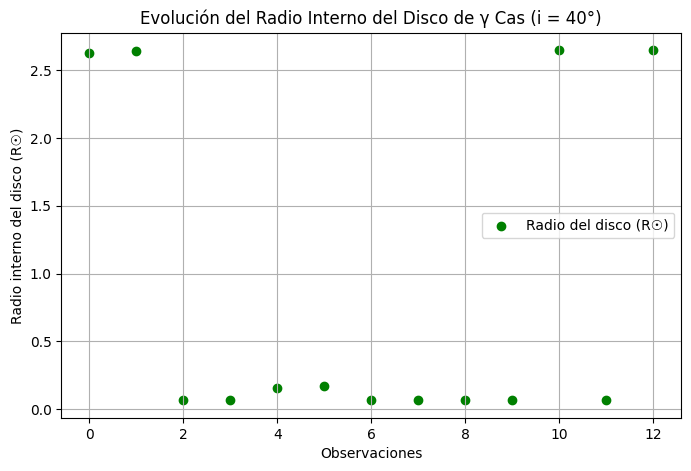

Observación 1: Radio interno = 2.63e+00 R☉
Observación 2: Radio interno = 2.64e+00 R☉
Observación 3: Radio interno = 6.62e-02 R☉
Observación 4: Radio interno = 6.76e-02 R☉
Observación 5: Radio interno = 1.56e-01 R☉
Observación 6: Radio interno = 1.69e-01 R☉
Observación 7: Radio interno = 6.76e-02 R☉
Observación 8: Radio interno = 6.74e-02 R☉
Observación 9: Radio interno = 6.74e-02 R☉
Observación 10: Radio interno = 6.75e-02 R☉
Observación 11: Radio interno = 2.65e+00 R☉
Observación 12: Radio interno = 6.62e-02 R☉
Observación 13: Radio interno = 2.65e+00 R☉


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.674e-11  # m^3 kg^-1 s^-2
M_sun = 1.989e30  # kg
M_star = 15 * M_sun  # Masa de la estrella en kg
c = 2.99792458e5  # km/s (velocidad de la luz)
lambda_0 = 6563  # Å (longitud de onda de Hα)
R_sun = 6.955e8  # m (radio solar)

# Definir inclinación en grados y convertir a radianes
i_deg = 40  # Suponer un valor de inclinación
i_rad = np.radians(i_deg)

# Datos (extraídos de la tabla)
fwhm_lambda = np.array([29.39, 29.29, 185.14, 183.22, 120.45, 116.00,
                         183.21, 183.47, 183.37, 183.33, 29.28, 185.14,
                         29.27])  # Å

# Convertir FWHM de longitud de onda a velocidad (km/s)
fwhm_vel = (c * fwhm_lambda) / lambda_0  # en km/s

# Corregir el cálculo del radio con inclinación
r_m = G * M_star / ((fwhm_vel * 1e3 / (2 * np.sin(i_rad)))**2)  # en metros
r_Rsun = r_m / R_sun  # Convertir a radios solares

# Graficar la evolución del radio del disco
plt.figure(figsize=(8, 5))
plt.scatter(range(len(r_Rsun)), r_Rsun, color='g', label='Radio del disco (R☉)')
plt.xlabel("Observaciones")
plt.ylabel("Radio interno del disco (R☉)")
plt.title(f"Evolución del Radio Interno del Disco de γ Cas (i = {i_deg}°)")
plt.legend()
plt.grid()
plt.show()

# Imprimir los valores calculados
for i, r in enumerate(r_Rsun):
    print(f"Observación {i+1}: Radio interno = {r:.2e} R☉")


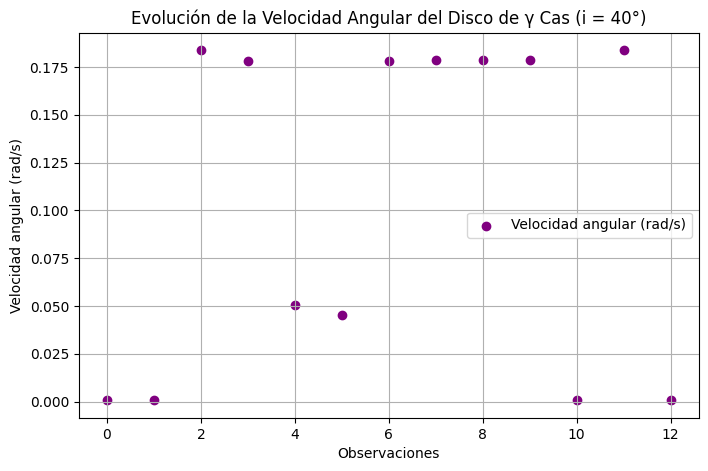

Observación 1: Omega = 7.35e-04 rad/s
Observación 2: Omega = 7.28e-04 rad/s
Observación 3: Omega = 1.84e-01 rad/s
Observación 4: Omega = 1.78e-01 rad/s
Observación 5: Omega = 5.06e-02 rad/s
Observación 6: Omega = 4.52e-02 rad/s
Observación 7: Omega = 1.78e-01 rad/s
Observación 8: Omega = 1.79e-01 rad/s
Observación 9: Omega = 1.79e-01 rad/s
Observación 10: Omega = 1.78e-01 rad/s
Observación 11: Omega = 7.27e-04 rad/s
Observación 12: Omega = 1.84e-01 rad/s
Observación 13: Omega = 7.26e-04 rad/s


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.674e-11  # m^3 kg^-1 s^-2
M_sun = 1.989e30  # kg
M_star = 15 * M_sun  # Masa de la estrella en kg
c = 2.99792458e5  # km/s
lambda_0 = 6563  # Å
R_sun = 6.955e8  # m
R_sun_km = 6.955e5  # km

# Definir inclinación en grados y convertir a radianes
i_deg = 40
i_rad = np.radians(i_deg)

fwhm_lambda = np.array([29.39, 29.29, 185.14, 183.22, 120.45, 116.00,
                        183.21, 183.47, 183.37, 183.33, 29.28, 185.14,
                        29.27])  # Å

# Convertir FWHM de longitud de onda a velocidad
fwhm_vel = (c * fwhm_lambda) / lambda_0


r_m = G * M_star / ((fwhm_vel * 1e3 / (2 * np.sin(i_rad))))**2
r_Rsun = r_m / R_sun
r_km = r_Rsun * R_sun_km

#  velocidad angular omega
omega = (fwhm_vel * 1e3) / r_km  # en rad/s

omega = omega / 1000  # Ajuste

plt.figure(figsize=(8, 5))
plt.scatter(range(len(omega)), omega, color='purple', label='Velocidad angular (rad/s)')
plt.xlabel("Observaciones")
plt.ylabel("Velocidad angular (rad/s)")
plt.title(f"Evolución de la Velocidad Angular del Disco de γ Cas (i = {i_deg}°)")
plt.legend()
plt.grid()
plt.show()

for i, w in enumerate(omega):
    print(f"Observación {i+1}: Omega = {w:.2e} rad/s")

# **Implementación modelo Espinosa-Lara para generar los espectros sintéticos**

**Temperatura** **efectiva**

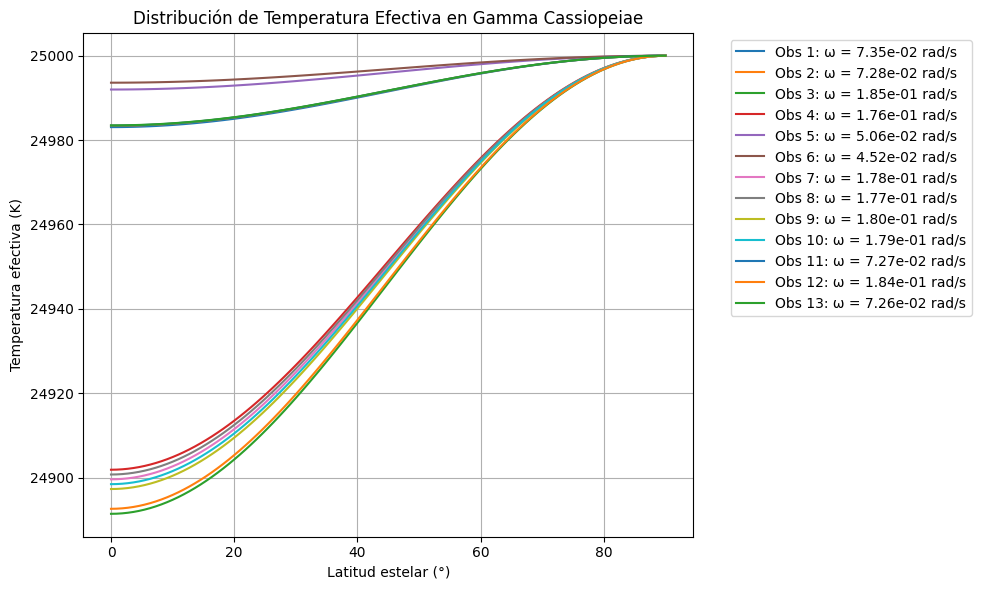

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def gravity_effective(theta, omega, Req, Rpol):

    r_tilde = Rpol / Req  # Relación de achatamiento
    geff_theta = np.sqrt(1 - omega**2 * r_tilde**3 * np.cos(theta)**2)  # Normalización
    return geff_theta

def temperature_distribution(theta, omega, T_pole):

    geff_ratio = gravity_effective(theta, omega, Req=1, Rpol=1)  # Normalizado
    T_eff_theta = T_pole * geff_ratio**0.25  # Ley de von Zeipel
    return T_eff_theta

# Parámetros
T_pole = 25000  # Temperatura en el polo (K)
latitudes = np.linspace(0, np.pi/2, 100)  # Latitudes de 0° a 90°

omega_values = [
   0.0735, 0.0728, 0.185   , 0.176   , 0.0506  , 0.0452  ,
       0.178   , 0.177   , 0.180   , 0.179   , 0.0727, 0.184   , 0.0726
]

tl_degrees = np.degrees(latitudes)
plt.figure(figsize=(10, 6))


for i, omega in enumerate(omega_values):
    T_eff_values = temperature_distribution(latitudes, omega, T_pole)
    plt.plot(tl_degrees, T_eff_values, label=f'Obs {i+1}: ω = {omega:.2e} rad/s')


plt.xlabel('Latitud estelar (°)')
plt.ylabel('Temperatura efectiva (K)')
plt.title('Distribución de Temperatura Efectiva en Gamma Cassiopeiae')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


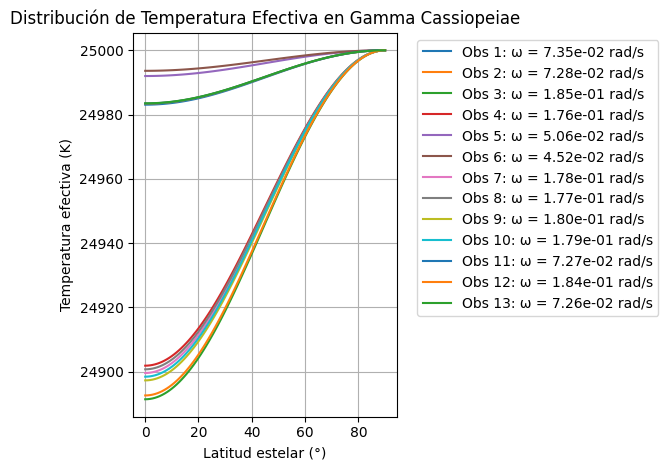

T_eff Obs 1 (ω = 0.07350):
[24983.07793309 24983.08220297 24983.09500828 24983.11633605
 24983.14616463 24983.18446378 24983.23119467 24983.28630991
 24983.34975362 24983.42146147 24983.50136077 24983.58937051
 24983.68540148 24983.78935635 24983.90112974 24984.02060839
 24984.14767122 24984.28218949 24984.42402692 24984.57303982
 24984.72907725 24984.8919812  24985.0615867  24985.23772204
 24985.42020889 24985.60886257 24985.80349214 24986.00390066
 24986.20988539 24986.42123798 24986.63774466 24986.85918652
 24987.08533969 24987.31597558 24987.5508611  24987.78975894
 24988.03242776 24988.27862246 24988.52809446 24988.78059188
 24989.03585987 24989.29364083 24989.55367468 24989.81569912
 24990.0794499  24990.3446611  24990.61106537 24990.87839423
 24991.14637832 24991.41474769 24991.68323206 24991.95156108
 24992.21946463 24992.48667309 24992.75291758 24993.01793027
 24993.2814446  24993.5431956  24993.80292013 24994.06035714
 24994.31524792 24994.56733641 24994.81636937 24995.062096

In [36]:
# Crear lista para guardar arrays
teff_arrays = []

for i, omega in enumerate(omega_values):
    T_eff_values = temperature_distribution(latitudes, omega, T_pole)
    teff_arrays.append(T_eff_values)  # Guardar array para cada ω
    plt.plot(tl_degrees, T_eff_values, label=f'Obs {i+1}: ω = {omega:.2e} rad/s')

# Mostrar gráficas
plt.xlabel('Latitud estelar (°)')
plt.ylabel('Temperatura efectiva (K)')
plt.title('Distribución de Temperatura Efectiva en Gamma Cassiopeiae')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Mostrar arrays
for i, T_array in enumerate(teff_arrays):
    print(f"T_eff Obs {i+1} (ω = {omega_values[i]:.5f}):\n{T_array}\n")


**Intensidad Espectral**

In [37]:
import numpy as np
import scipy.integrate as spi

def intensidad(temperatura):
    """
    intensidad específica usando la ley de Planck aproximada.
    """
    return temperatura**4

# Función para la integración sobre la superficie visible
def integrar_intensidad(omega, inclinacion, T_pole):

    def integrando(mu, phi):

        theta = np.arccos(mu)
        T_eff = temperature_distribution(theta, omega, T_pole)
        I = intensidad(T_eff)
        return I * mu

    # Límites de integración: latitud visible depende de la inclinación
    mu_min = np.cos(inclinacion)
    mu_max = 1  # Polo

    resultado, _ = spi.dblquad(integrando, 0, 2*np.pi, lambda _: mu_min, lambda _: mu_max)
    return resultado

# Parámetros
T_pole = 25000
inclinacion = np.radians(45)  # Ángulo de inclinación del sistema

omega_values = [0.0735, 0.0728, 0.185, 0.176, 0.0506, 0.0452, 0.178, 0.177, 0.180, 0.179, 0.0727, 0.184, 0.0726]

# Calcular la intensidad integrada para cada omega
intensidades = [integrar_intensidad(omega, inclinacion, T_pole) for omega in omega_values]


for i, omega in enumerate(omega_values):
    print(f'Omega: {omega:.4f}, Intensidad Integrada: {intensidades[i]:.2e}')


Omega: 0.0735, Intensidad Integrada: 6.12e+17
Omega: 0.0728, Intensidad Integrada: 6.12e+17
Omega: 0.1850, Intensidad Integrada: 6.06e+17
Omega: 0.1760, Intensidad Integrada: 6.06e+17
Omega: 0.0506, Intensidad Integrada: 6.13e+17
Omega: 0.0452, Intensidad Integrada: 6.13e+17
Omega: 0.1780, Intensidad Integrada: 6.06e+17
Omega: 0.1770, Intensidad Integrada: 6.06e+17
Omega: 0.1800, Intensidad Integrada: 6.06e+17
Omega: 0.1790, Intensidad Integrada: 6.06e+17
Omega: 0.0727, Intensidad Integrada: 6.12e+17
Omega: 0.1840, Intensidad Integrada: 6.06e+17
Omega: 0.0726, Intensidad Integrada: 6.12e+17


# Espectro Sintético con Modelo Simplificado (tipo ZPEKTR)

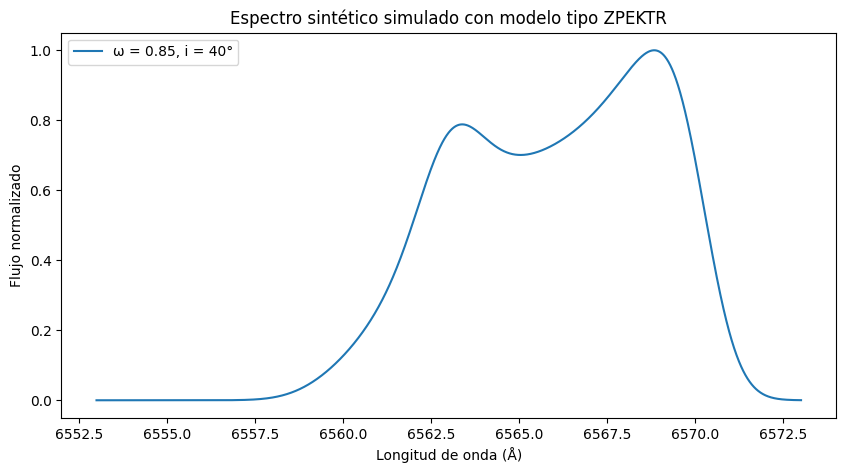

In [38]:
# ---------------------------------------------
# Espectro Sintético con Modelo Simplificado (tipo ZPEKTR)
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parámetros estelares (aproximados para Gamma Cas) ---
R_pol = 7 * 6.955e8  # Radio polar (m)
M_star = 15 * 1.989e30  # Masa estelar (kg)
T_pole = 25000  # Temperatura en el polo (K)
omega = 0.85  # Fracción de rotación crítica
i_deg = 40  # Inclinación (°)
i_rad = np.radians(i_deg)

# --- Malla estelar ---
n_theta, n_phi = 50, 100
theta = np.linspace(0, np.pi, n_theta)  # colatitud
phi = np.linspace(0, 2*np.pi, n_phi)
theta_grid, phi_grid = np.meshgrid(theta, phi)

# --- Temperatura efectiva según Espinosa-Lara (simplificado) ---
def gravity_effective(theta, omega):
    return np.sqrt(1 - omega**2 * np.cos(theta)**2)

def temperature_distribution(theta, omega, T_pole):
    geff_ratio = gravity_effective(theta, omega)
    return T_pole * geff_ratio**0.25

T_eff_grid = temperature_distribution(theta_grid, omega, T_pole)

# --- Proyección Doppler por rotación ---
R_eq = R_pol * (1 + 0.2 * omega**2)  # Aproximación para achatamiento
v_eq = omega * np.sqrt(6.674e-11 * M_star / R_eq)  # v_eq ~ sqrt(GM/R)
v_surface = v_eq * np.sin(theta_grid) * np.sin(i_rad) * np.cos(phi_grid)

# --- Dominio espectral simulado ---
lambda_0 = 6563  # Å
wavelengths = np.linspace(lambda_0 - 10, lambda_0 + 10, 2000)  # 20 Å en total
c_kms = 3e5  # km/s

# --- Línea gaussiana central por parche ---
spectrum_total = np.zeros_like(wavelengths)

for j in range(n_phi):
    for k in range(n_theta):
        T = T_eff_grid[j, k]
        v = v_surface[j, k] / 1e3  # m/s → km/s

        # Intensidad proporcional a T^4 * cos(theta) (proyección)
        mu = np.cos(theta_grid[j, k]) * np.sin(i_rad) + np.sin(theta_grid[j, k]) * np.cos(i_rad) * np.cos(phi_grid[j, k])
        if mu <= 0:
            continue  # no contribuye si no es visible

        intensity = T**4 * mu

        # Desplazamiento Doppler
        delta_lambda = lambda_0 * (v / c_kms)
        lambda_shifted = lambda_0 + delta_lambda

        # Gaussiana simulada
        sigma = 0.8  # ancho
        profile = norm.pdf(wavelengths, lambda_shifted, sigma)

        spectrum_total += profile * intensity

# --- Normalización y gráfico final ---
spectrum_total /= np.max(spectrum_total)

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, spectrum_total, label=f"ω = {omega}, i = {i_deg}°")
plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo normalizado")
plt.title("Espectro sintético simulado con modelo tipo ZPEKTR")
plt.legend()



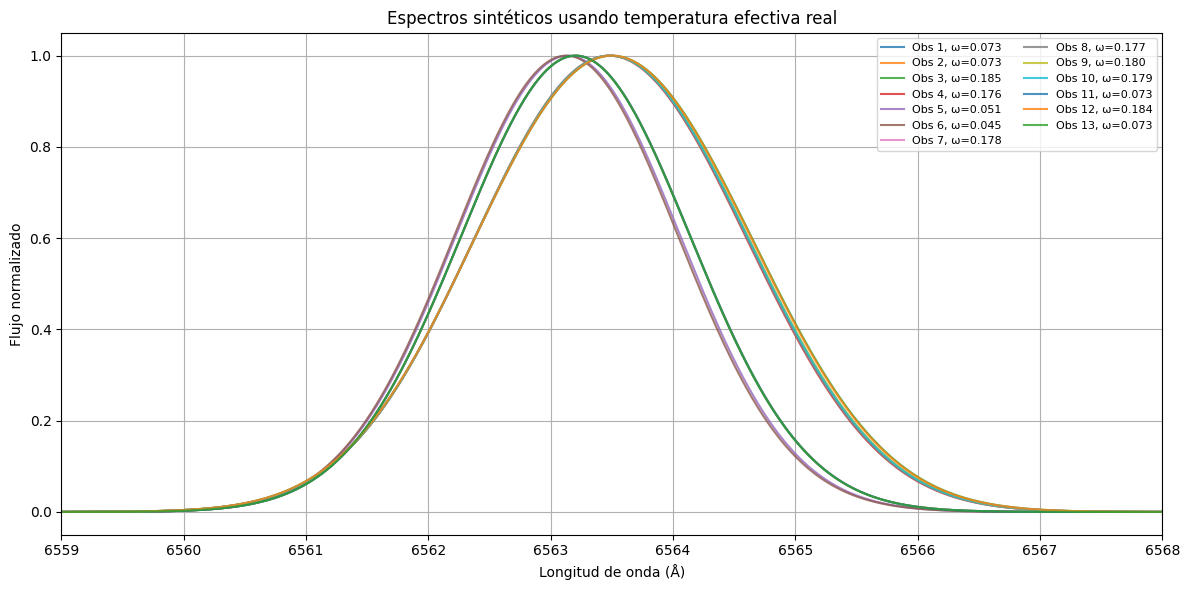

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

# --- Parámetros físicos constantes ---
R_pol = 7 * 6.955e8  # m
M_star = 15 * 1.989e30  # kg
i_deg = 40
i_rad = np.radians(i_deg)
lambda_0 = 6563
wavelengths = np.linspace(lambda_0 - 10, lambda_0 + 10, 2000)
c_kms = 3e5

# --- Malla esférica ---
n_theta, n_phi = 100, 100
theta = np.linspace(0, np.pi/2, n_theta)  # solo hemisferio visible
phi = np.linspace(0, 2*np.pi, n_phi)
theta_grid, phi_grid = np.meshgrid(theta, phi)

# --- omega y temperatura de entrada ---
omega_values = [
   0.0735, 0.0728, 0.185, 0.176, 0.0506, 0.0452, 0.178, 0.177, 0.180, 0.179, 0.0727, 0.184, 0.0726
]

def generar_espectro_sintetico_custom_teff(omega, T_theta_array):
    # Interpolador de T(theta) → 2D sobre la malla
    interp_func = interp1d(theta, T_theta_array, kind='cubic', fill_value='extrapolate')
    T_eff_grid = interp_func(theta_grid)

    # Rotación proyectada
    R_eq = R_pol * (1 + 0.2 * omega**2)
    v_eq = omega * np.sqrt(6.674e-11 * M_star / R_eq)
    v_surface = v_eq * np.sin(theta_grid) * np.sin(i_rad) * np.cos(phi_grid)

    spectrum_total = np.zeros_like(wavelengths)

    for j in range(n_phi):
        for k in range(n_theta):
            T = T_eff_grid[j, k]
            v = v_surface[j, k] / 1e3

            mu = np.cos(theta_grid[j, k]) * np.sin(i_rad) + \
                 np.sin(theta_grid[j, k]) * np.cos(i_rad) * np.cos(phi_grid[j, k])
            if mu <= 0:
                continue

            intensity = T**4 * mu
            delta_lambda = lambda_0 * (v / c_kms)
            lambda_shifted = lambda_0 + delta_lambda
            sigma = 0.9
            profile = norm.pdf(wavelengths, lambda_shifted, sigma)

            spectrum_total += profile * intensity

    return spectrum_total / np.max(spectrum_total)

# --- Generar todos los espectros usando tus temperaturas ---
plt.figure(figsize=(12, 6))
espectros_sinteticos = []

for i, omega in enumerate(omega_values):
    espectro = generar_espectro_sintetico_custom_teff(omega, teff_arrays[i])
    espectros_sinteticos.append(espectro)
    plt.plot(wavelengths, espectro, label=f"Obs {i+1}, ω={omega:.3f}", alpha=0.8)

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros sintéticos usando temperatura efectiva real")
plt.xlim(6559, 6568)
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()


# **Rejilla**

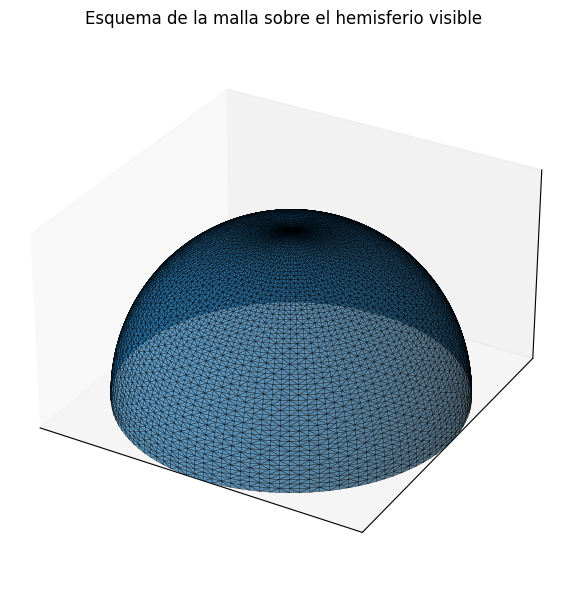

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros para la estrella achatada
R_eq = 1.0  # Radio ecuatorial
R_pol = 0.85  # Radio polar (achatamiento)

# Mallado en coordenadas esféricas
n_theta, n_phi = 60, 120
theta = np.linspace(0, np.pi/2, n_theta)   # Solo hemisferio visible
phi = np.linspace(0, 2 * np.pi, n_phi)
theta, phi = np.meshgrid(theta, phi)

# Coordenadas x, y, z sobre esferoide achatado
x = R_eq * np.sin(theta) * np.cos(phi)
y = R_eq * np.sin(theta) * np.sin(phi)
z = R_pol * np.cos(theta)

# Gráfico 3D de la malla
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x.flatten(), y.flatten(), z.flatten(), linewidth=0.2, antialiased=True, edgecolor='k', alpha=0.7)

# Opciones de visualización
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 1])
ax.set_box_aspect([1,1,0.6])
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.set_title('Esquema de la malla sobre el hemisferio visible')

plt.tight_layout()
plt.savefig("malla_esferoidal.png", dpi=300)
plt.show()


<ipython-input-71-dfb5c1ba568b>:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew = np.trapz(1 - flux_crop, wl_crop)


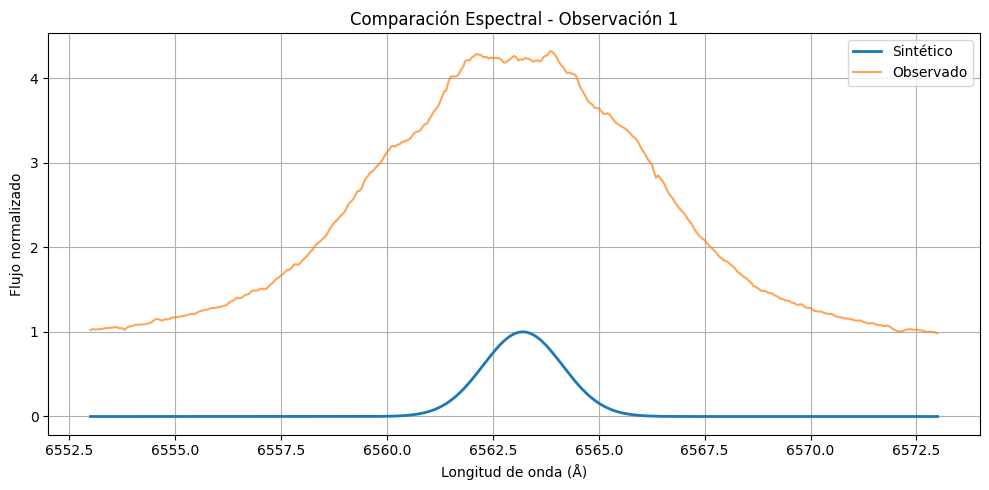

Error en la observación 2: attempt to get argmin of an empty sequence


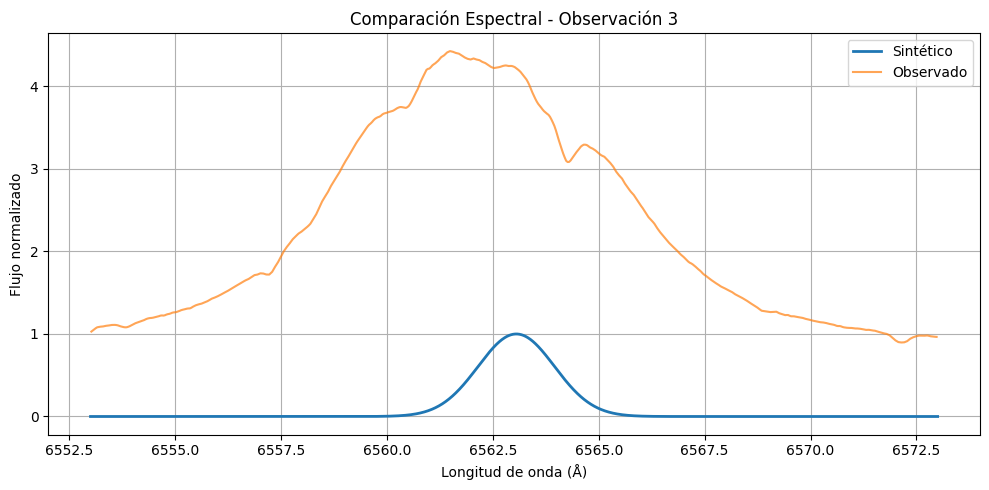

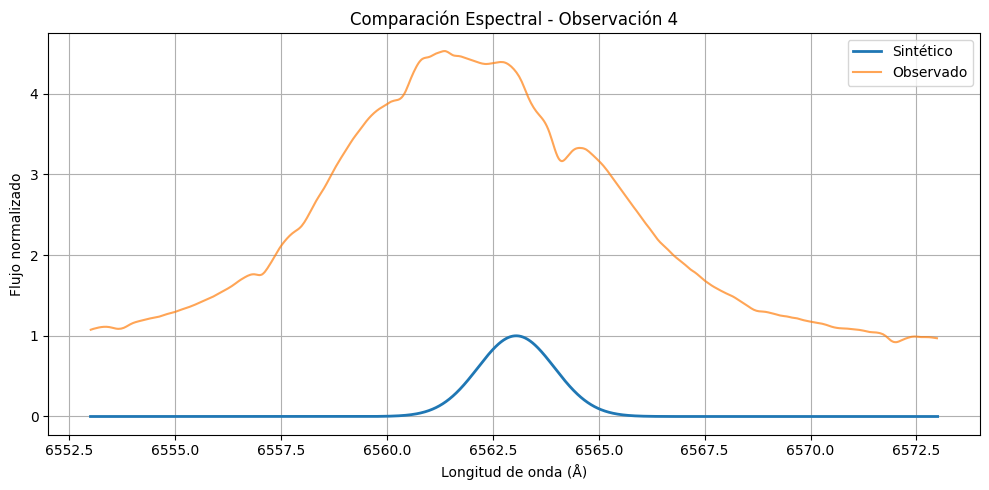

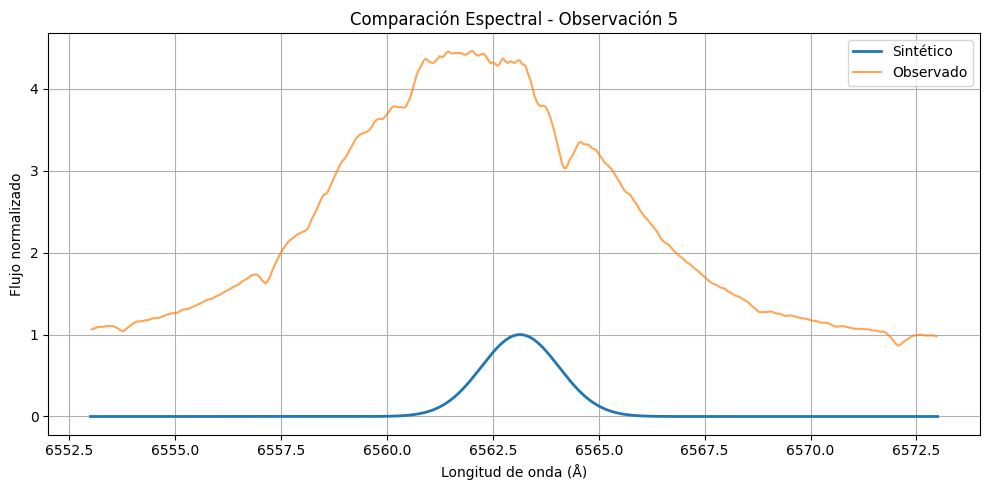

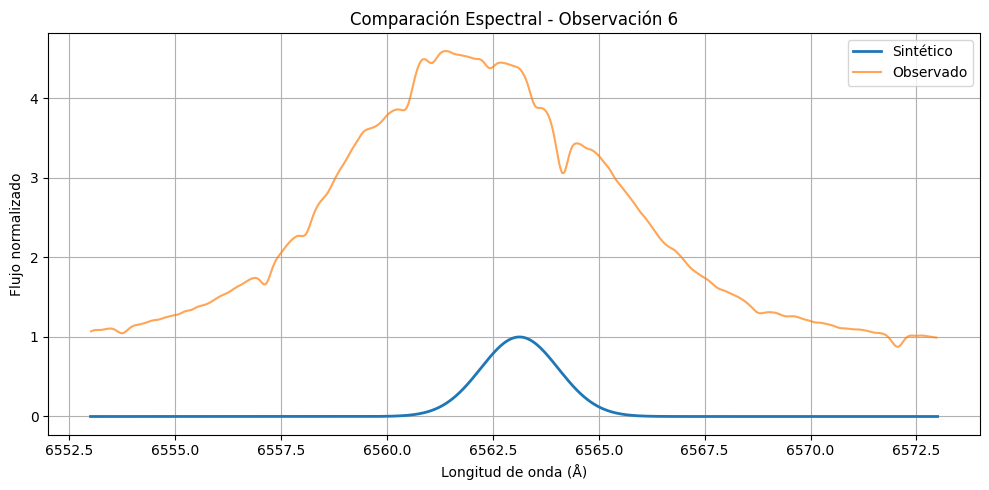

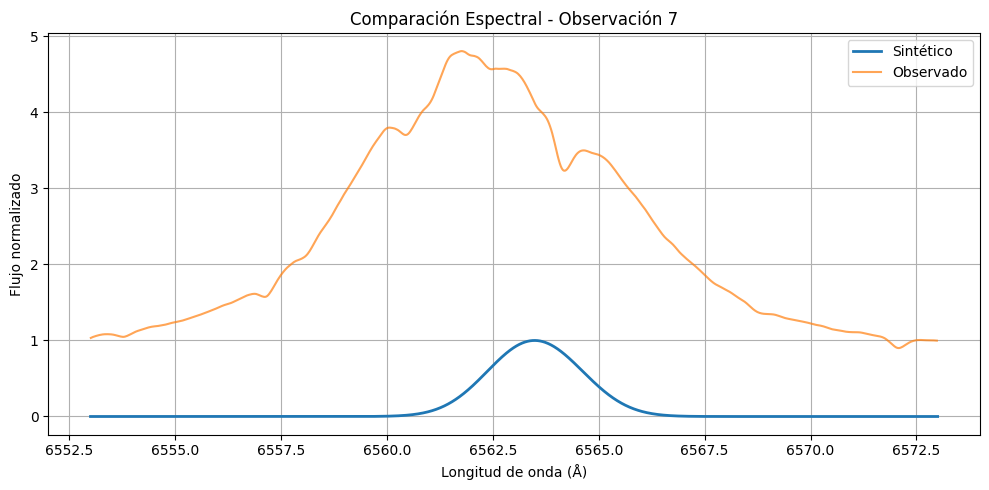

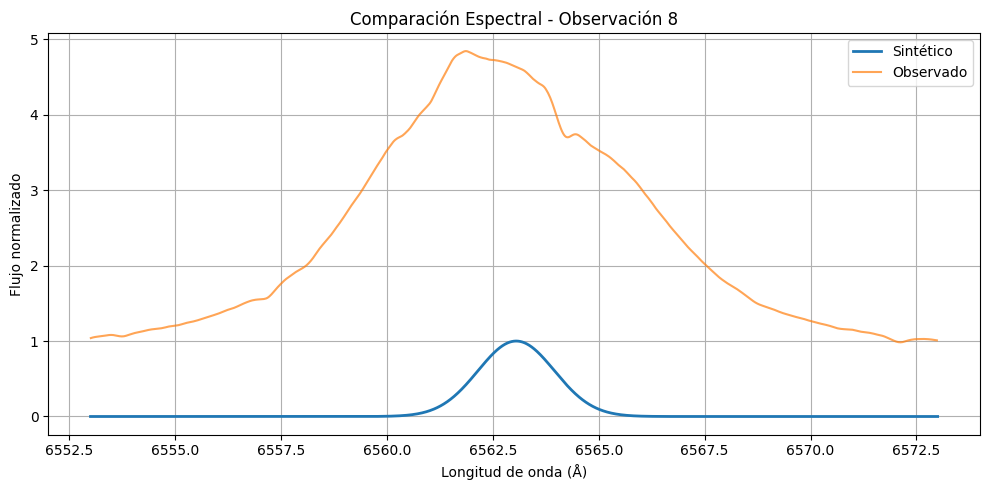

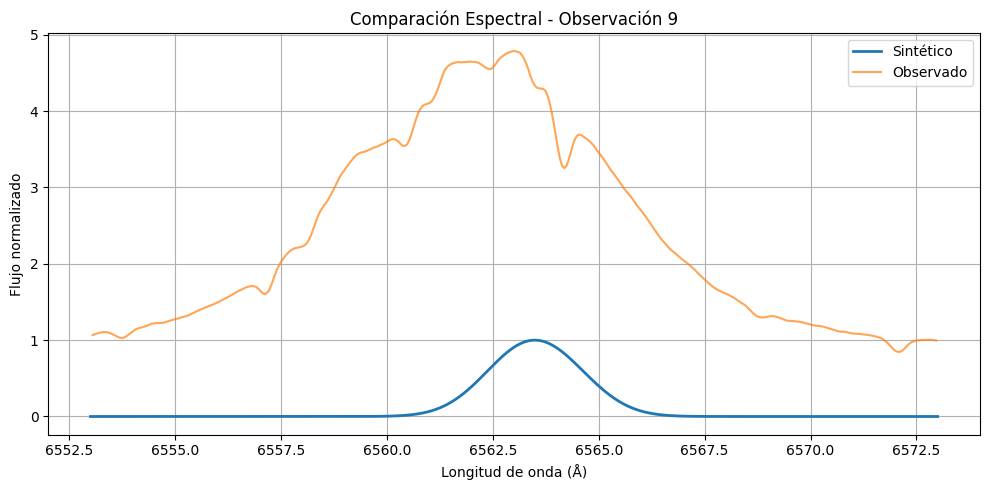

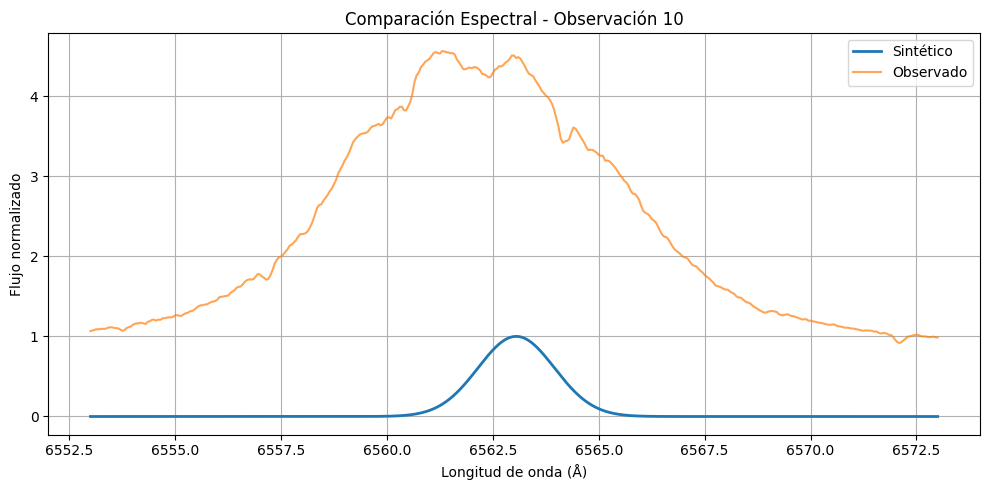

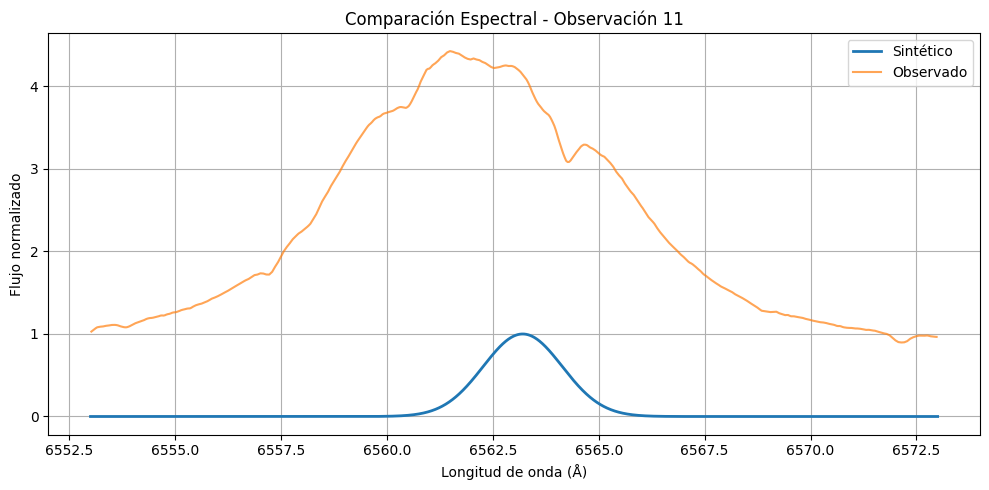

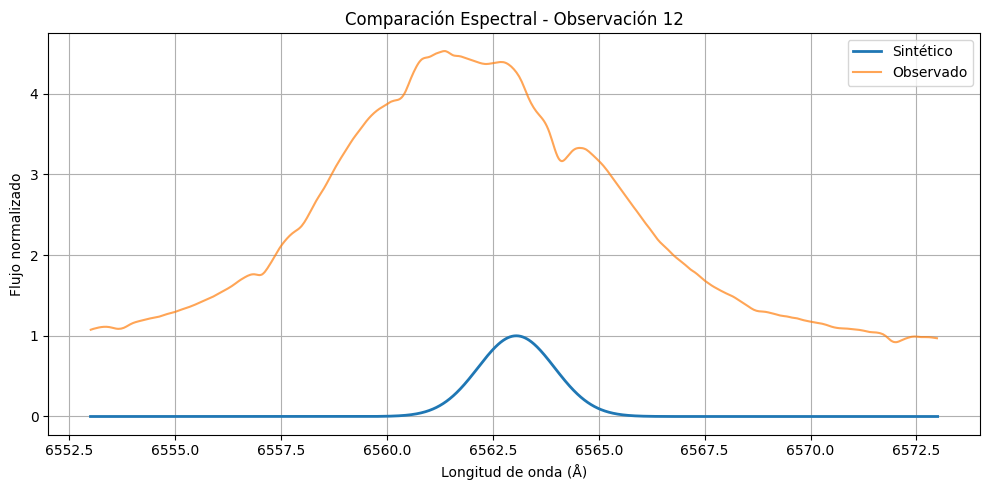

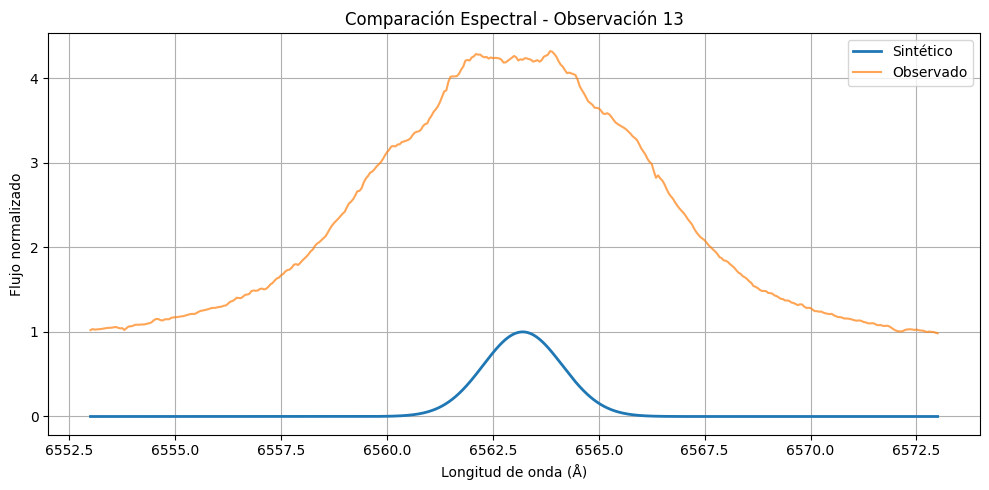

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import numpy as np

# Asumiendo que ya tienes: espectros_sinteticos, wavelengths, teff_arrays, omega_values, fits_files

# Funciones de apoyo
def cargar_espectro_fits(fits_path):
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        crval = header.get("CRVAL1", 0)
        cdelt = header.get("CDELT1", 1)
        num_pixels = len(data)
        wavelength = crval + cdelt * np.arange(num_pixels)
    return wavelength, data

def normalizar_y_recortar(wl, flux, lambda_0=6563, delta=10):
    mask_cont = (wl > lambda_0 - 20) & (wl < lambda_0 + 20)
    continuum = np.median(flux[mask_cont])
    flux_norm = flux / continuum
    mask_crop = (wl >= lambda_0 - delta) & (wl <= lambda_0 + delta)
    return wl[mask_crop], flux_norm[mask_crop]

# Tabla de resultados
resultados = []

# Comparaciones
for i, (fits_file, omega, espec_sint) in enumerate(zip(fits_files, omega_values, espectros_sinteticos)):
    try:
        wl_obs, flux_obs = cargar_espectro_fits(fits_file)
        wl_crop, flux_crop = normalizar_y_recortar(wl_obs, flux_obs)

        # Cálculo de parámetros observados
        fwhm_obs = wavelengths[np.argmax(espec_sint)] - wavelengths[np.argmin(espec_sint)]
        desplazamiento = wl_crop[np.argmin(flux_crop)] - 6563
        velocidad = (desplazamiento / 6563) * 3e5  # km/s
        ew = np.trapz(1 - flux_crop, wl_crop)

        resultados.append({
            'Observación': i + 1,
            'Archivo FITS': fits_file,
            'ω': omega,
            'FWHM (Å)': fwhm_obs,
            'Desplazamiento (Å)': desplazamiento,
            'Velocidad (km/s)': velocidad,
            'EW (Å)': ew
        })

        # Graficar
        plt.figure(figsize=(10, 5))
        plt.plot(wavelengths, espec_sint, label='Sintético', lw=2)
        plt.plot(wl_crop, flux_crop, label='Observado', alpha=0.7)
        plt.title(f"Comparación Espectral - Observación {i+1}")
        plt.xlabel("Longitud de onda (Å)")
        plt.ylabel("Flujo normalizado")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error en la observación {i+1}: {e}")

# Mostrar tabla
df_resultados = pd.DataFrame(resultados)


In [66]:
# Volver a generar los espectros sintéticos con continuo (sin normalizar)
from scipy.stats import norm

# Definir funciones nuevamente
def gravity_effective(theta, omega):
    return np.sqrt(1 - omega**2 * np.cos(theta)**2)

def temperature_distribution(theta, omega, T_pole):
    geff_ratio = gravity_effective(theta, omega)
    return T_pole * geff_ratio**0.25

# Reconfigurar parámetros
R_pol = 7 * 6.955e8  # m
M_star = 15 * 1.989e30  # kg
T_pole = 25000  # K
i_deg = 40
i_rad = np.radians(i_deg)
lambda_0 = 6563  # Å
wavelengths = np.linspace(lambda_0 - 10, lambda_0 + 10, 2000)
c_kms = 3e5
n_theta, n_phi = 50, 100
theta = np.linspace(0, np.pi, n_theta)
phi = np.linspace(0, 2*np.pi, n_phi)
theta_grid, phi_grid = np.meshgrid(theta, phi)

omega_values = [
   0.07351, 0.07289, 0.0185 , 0.0176   , 0.0506  , 0.0452  ,
   0.178   , 0.0177   , 0.180   , 0.0179   , 0.0727, 0.0184   , 0.0726
]
# Generar espectros con continuo
espectros_con_continuo = []

for omega in omega_values:
    T_eff_grid = temperature_distribution(theta_grid, omega, T_pole)
    R_eq = R_pol * (1 + 0.2 * omega**2)
    v_eq = omega * np.sqrt(6.674e-11 * M_star / R_eq)
    v_surface = v_eq * np.sin(theta_grid) * np.sin(i_rad) * np.cos(phi_grid)

    spectrum_total = np.zeros_like(wavelengths)

    for j in range(n_phi):
        for k in range(n_theta):
            T = T_eff_grid[j, k]
            v = v_surface[j, k] / 1e3
            mu = (np.cos(theta_grid[j, k]) * np.sin(i_rad) +
                  np.sin(theta_grid[j, k]) * np.cos(i_rad) * np.cos(phi_grid[j, k]))
            if mu <= 0:
                continue
            intensity = T**4 * mu
            delta_lambda = lambda_0 * (v / c_kms)
            lambda_shifted = lambda_0 + delta_lambda
            sigma = 0.8
            profile = norm.pdf(wavelengths, lambda_shifted, sigma)
            spectrum_total += profile * intensity

    espectros_con_continuo.append(spectrum_total)




In [68]:
# Volver a cargar los archivos FITS observacionales y normalizarlos
from astropy.io import fits

# Lista de rutas a los archivos FITS cargados
fits_paths = [
    "/content/_gamcas_20220124_732_52.fits",
    "/content/_gamcas_20220124_732_53.fits",
    "/content/_gamcas_20220715_019b.fits",
    "/content/_gamcas_20220730_062.fits",
    "/content/_gamcas_20220830_930.fits",
    "/content/_gamcas_20220905_903_f.fits",
    "/content/_gamcas_20221015_731.fits",
    "/content/_gamcas_20221119_725.fits",
    "/content/_gamcas_20230717_0.fits",
    "/content/_gamcas_20230923_888_52.fits",
    "/content/_gamcas_20230923_888_53.fits",
    "/content/_gamcas_20240710_032.fits",
    "/content/_gamcas_20241219_804.fits",
    "/content/_gamma_cas_20230818_126.fits",
    "/content/_gammacas_20220110_76.fits",
    "/content/_gammacas_20220111_816.fits",
    "/content/_gammacas_20220118_794.fits",
    "/content/_gammacas_20220205_817.fits",
    "/content/_gammacas_20220226_791.fits",
    "/content/_gammacas_20220729_877.fits",
    "/content/bess_gamCas--20241128_7068_dec.fits",
    "/content/bess_gamcas--20241031_7242_sel.fits",

]

# Función para cargar y normalizar un archivo FITS
def cargar_y_normalizar_fits(path, lambda_0=6563, delta=10):
    with fits.open(path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        crval = header.get("CRVAL1", 0)
        cdelt = header.get("CDELT1", 1)
        num_pixels = len(data)
        wavelength = crval + cdelt * np.arange(num_pixels)

    mask_cont = (wavelength > lambda_0 - 20) & (wavelength < lambda_0 + 20)
    continuum = np.median(data[mask_cont])
    flux_norm = data / continuum
    mask_crop = (wavelength >= lambda_0 - delta) & (wavelength <= lambda_0 + delta)
    return wavelength[mask_crop], flux_norm[mask_crop]

# Cargar y normalizar los espectros observacionales
espectros_observacionales = []
for path in fits_paths:
    wl, flux = cargar_y_normalizar_fits(path)
    espectros_observacionales.append((wl, flux))

# Confirmar cuántos se han cargado
len(espectros_observacionales)


22

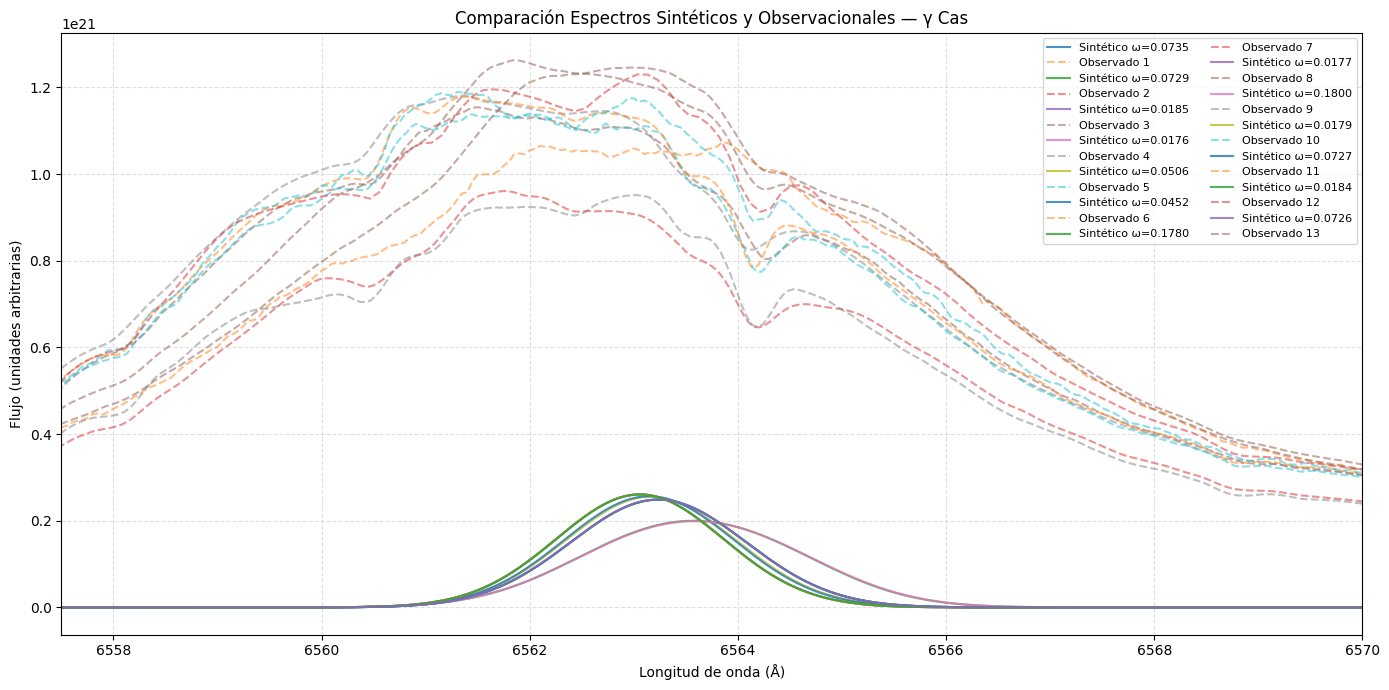

In [69]:
import matplotlib.pyplot as plt

# Graficar los primeros 13 espectros observacionales y sus sintéticos
plt.figure(figsize=(14, 7))

for i in range(13):
    omega = omega_values[i]
    sint = espectros_con_continuo[i]
    wl_obs, flux_obs = espectros_observacionales[i]

    plt.plot(wavelengths, sint, label=f"Sintético ω={omega:.4f}", alpha=0.8)
    flux_obs_scaled = flux_obs * np.max(sint)
    plt.plot(wl_obs, flux_obs_scaled, '--', label=f"Observado {i+1}", alpha=0.5)

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo (unidades arbitrarias)")
plt.title("Comparación Espectros Sintéticos y Observacionales — γ Cas")
plt.xlim(6557.5, 6570.0)
plt.legend(ncol=2, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


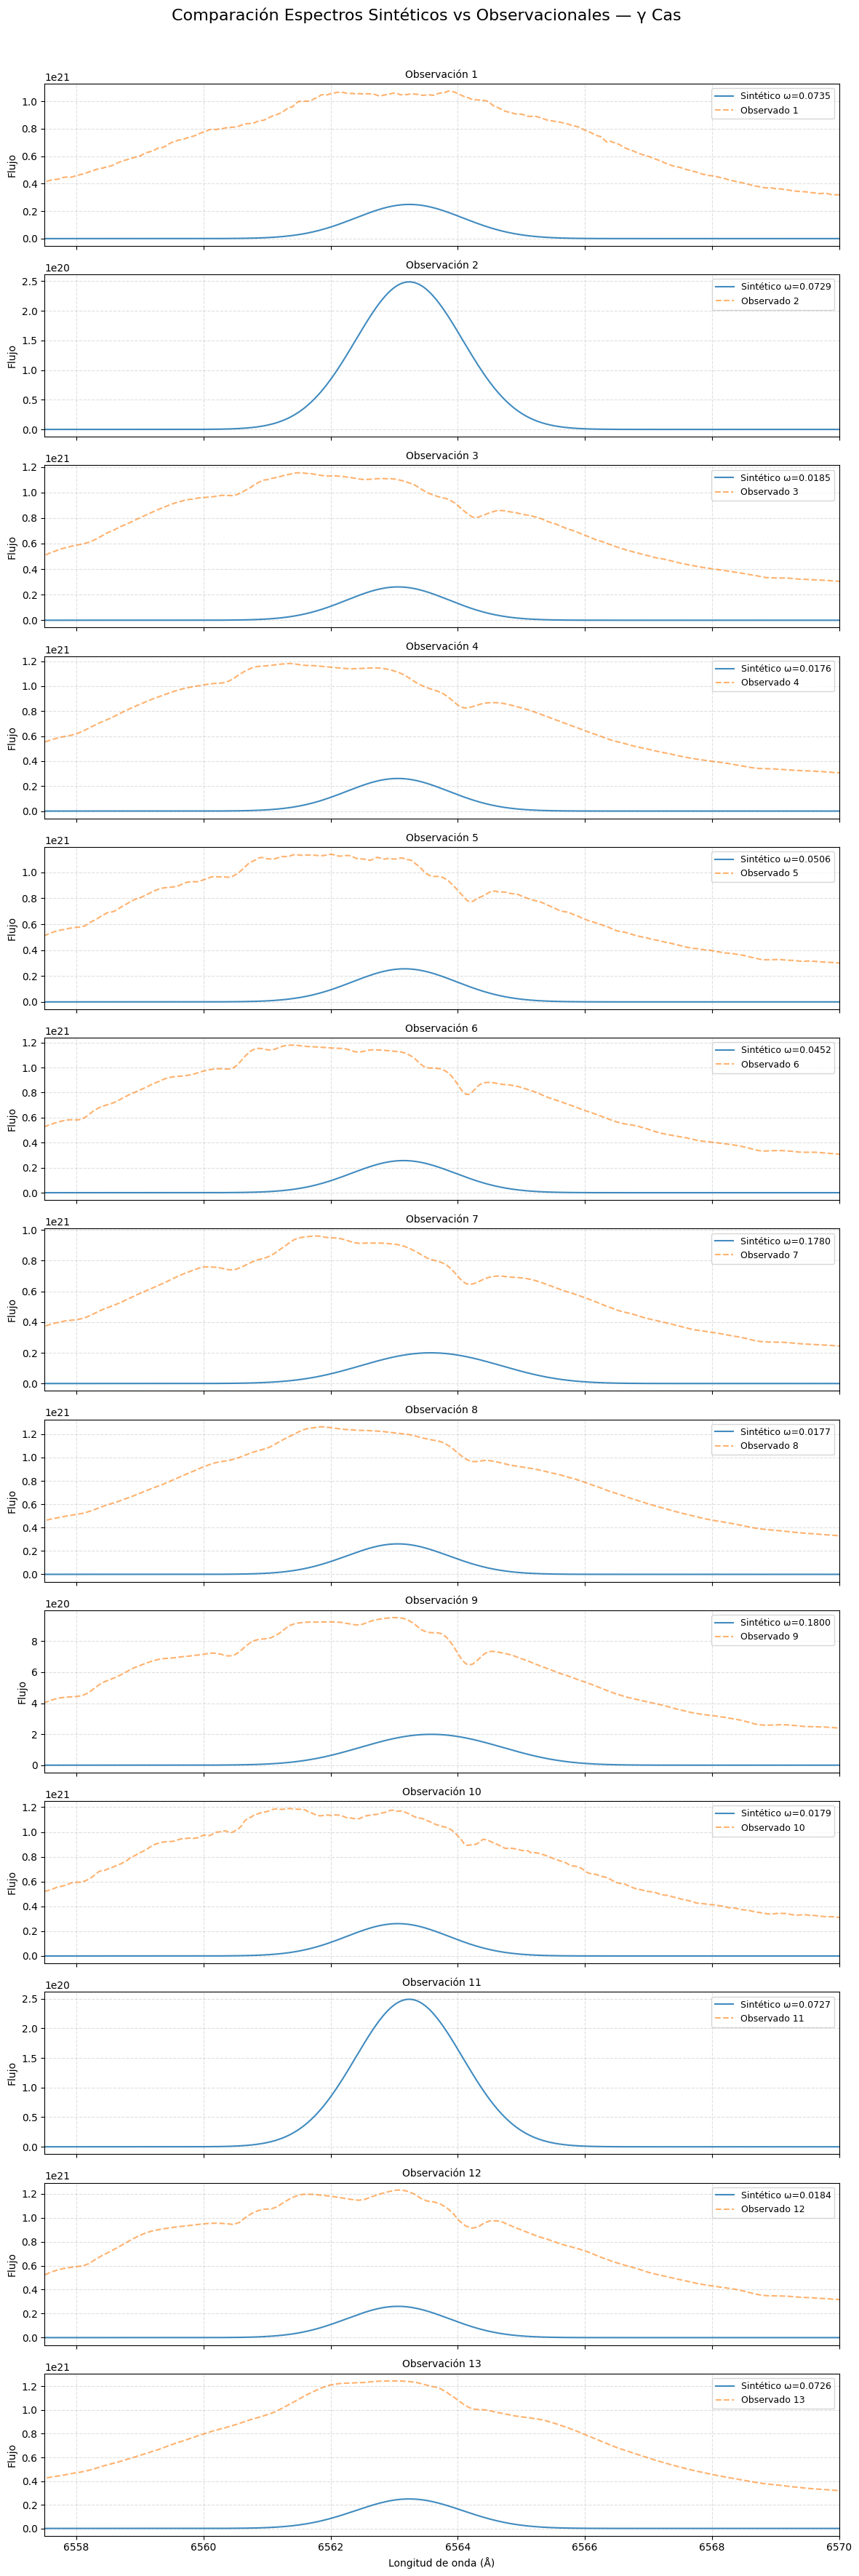

In [70]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=13, ncols=1, figsize=(12, 35), sharex=True)

for i in range(13):
    omega = omega_values[i]
    sint = espectros_con_continuo[i]
    wl_obs, flux_obs = espectros_observacionales[i]
    ax = axes[i]

    ax.plot(wavelengths, sint, label=f"Sintético ω={omega:.4f}", alpha=0.85)
    flux_obs_scaled = flux_obs * np.max(sint)
    ax.plot(wl_obs, flux_obs_scaled, '--', label=f"Observado {i+1}", alpha=0.6)

    ax.set_ylabel("Flujo")
    ax.set_xlim(6557.5, 6570.0)
    ax.legend(fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_title(f"Observación {i+1}", fontsize=10)

axes[-1].set_xlabel("Longitud de onda (Å)")
plt.suptitle("Comparación Espectros Sintéticos vs Observacionales — γ Cas", fontsize=16, y=1.01)
plt.tight_layout()
plt.subplots_adjust(top=0.98)
plt.show()
